In [78]:
import numpy as np
import pandas as pd
from pathlib import Path

np.random.seed(42)

DATA_RAW_PATH = Path('..\\data\\raw')

#This dataset contains raw data from the original dataset where the rows containg missing values where dropped
data_raw_dropped = pd.read_csv(DATA_RAW_PATH/'version_dropped.csv', index_col='customerID')

# Models Based On Raw Data

## Version Missing Values Dropped

In [79]:
data_raw_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7010 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7010 non-null   object 
 1   SeniorCitizen     7010 non-null   int64  
 2   Partner           7010 non-null   object 
 3   Dependents        7010 non-null   object 
 4   tenure            7010 non-null   int64  
 5   PhoneService      7010 non-null   object 
 6   MultipleLines     7010 non-null   object 
 7   InternetService   7010 non-null   object 
 8   OnlineSecurity    7010 non-null   object 
 9   OnlineBackup      7010 non-null   object 
 10  DeviceProtection  7010 non-null   object 
 11  TechSupport       7010 non-null   object 
 12  StreamingTV       7010 non-null   object 
 13  StreamingMovies   7010 non-null   object 
 14  Contract          7010 non-null   object 
 15  PaperlessBilling  7010 non-null   object 
 16  PaymentMethod     7010 non-null 

In [80]:
X = data_raw_dropped.drop('Churn', axis=1)
y = data_raw_dropped['Churn']

In [81]:
numerical_col = X.select_dtypes('number').columns
categorical_col = X.select_dtypes(exclude='number').columns
target_col = y.name

In [82]:
numerical_col[1: ]

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [83]:
categorical_col

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [84]:
target_col

'Churn'

In [85]:
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler

inputs_processor = make_column_transformer(
    (OrdinalEncoder(), categorical_col),
    (StandardScaler(), numerical_col)
)

target_enc = LabelEncoder()

raw_data_pipeline = Pipeline([('preprocessing raw data', inputs_processor)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train = raw_data_pipeline.fit_transform(X_train)
y_train = target_enc.fit_transform(y_train)

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)
lr_clf = LogisticRegression(random_state=42, n_jobs=-1)
knn_clf = KNeighborsClassifier(n_jobs=-1)
svm_clf = SVC(random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42)

models = [rf_clf, lr_clf, knn_clf, svm_clf, tree_clf]

In [87]:
from time import time

for model in models:
    print(f'{model} is training')
    training_start = time()
    model.fit(X_train, y_train)
    training_end = time() - training_start
    print(f'{model} has complete training in {training_end}')

RandomForestClassifier(n_jobs=-1, random_state=42) is training
RandomForestClassifier(n_jobs=-1, random_state=42) has complete training in 0.4814920425415039
LogisticRegression(n_jobs=-1, random_state=42) is training
LogisticRegression(n_jobs=-1, random_state=42) has complete training in 0.0335841178894043
KNeighborsClassifier(n_jobs=-1) is training
KNeighborsClassifier(n_jobs=-1) has complete training in 0.0008909702301025391
SVC(random_state=42) is training
SVC(random_state=42) has complete training in 0.8574063777923584
DecisionTreeClassifier(random_state=42) is training
DecisionTreeClassifier(random_state=42) has complete training in 0.030678272247314453


In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

X_test = raw_data_pipeline.transform(X_test)
y_test = target_enc.transform(y_test)

models_df = pd.DataFrame()
models_data = {'Model': [], 'Train Accuracy': [],'Test Accuracy': [], 'Precision': [], 'Recall': []}

for model in models:
    y_pred = model.predict(X_test)
    models_data['Model'].append(model)
    models_data['Train Accuracy'].append(model.score(X_train, y_train))
    models_data['Test Accuracy'].append(round(accuracy_score(y_test, y_pred), 2))
    models_data['Precision'].append(round(precision_score(y_test, y_pred), 2))
    models_data['Recall'].append(round(recall_score(y_test, y_pred), 2))
    

In [89]:
models_df = pd.DataFrame(models_data)
models_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall
0,"(DecisionTreeClassifier(max_features='sqrt', r...",0.998039,0.79,0.66,0.46
1,"LogisticRegression(n_jobs=-1, random_state=42)",0.804922,0.81,0.66,0.54
2,KNeighborsClassifier(n_jobs=-1),0.833452,0.76,0.54,0.47
3,SVC(random_state=42),0.817225,0.79,0.67,0.45
4,DecisionTreeClassifier(random_state=42),0.998039,0.72,0.47,0.49


In [97]:
models_df['Model'] = ['Random Forest', 'Logistic', 'KNN', 'SVM', 'Tree']

Text(0.5, 1.0, 'Models Performance')

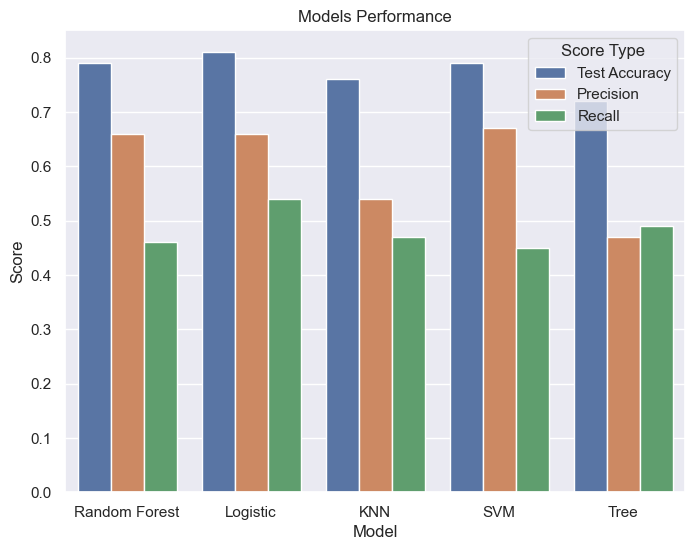

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))

sns.set_theme()
models_df_melt = pd.melt(models_df, 'Model', ['Test Accuracy', 'Precision', 'Recall'],
                         var_name='Score Type', value_name='Score')

sns.barplot(models_df_melt, x='Model', y='Score', hue='Score Type', ax=ax)

ax.set_title('Models Performance')

In [ ]:
from sklearn.model_selection import GridSearchCV

svc_params = {
    'C': range(1, 10),
    'kernel': ['poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(SVC(), svc_params, n_jobs=-1, cv=5, verbose=4)
grid_svc.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,SVC()
,param_grid,"{'C': range(1, 10), 'gamma': ['scale', 'auto'], 'kernel': ['poly', 'sigmoid']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,4
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [ ]:
y_pred = grid_svc.best_estimator_.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

Accuracy: 0.8038516405135521
Precision: 0.6951219512195121
Recall: 0.4609164420485175


In [ ]:
lr_params = {'C': range(1, 10)}

grid_lr = GridSearchCV(LogisticRegression(), lr_params, n_jobs=-1, cv=5, verbose=4)
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,LogisticRegression()
,param_grid,"{'C': range(1, 10)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,4
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [ ]:
y_pred = grid_lr.best_estimator_.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

Accuracy: 0.8088445078459344
Precision: 0.6565349544072948
Recall: 0.5822102425876011
